In [1]:
from IPython import get_ipython


In [2]:
get_ipython().run_line_magic("reload_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")
get_ipython().run_line_magic("matplotlib", "inline")



In [3]:
from fastai.vision import *
from fastai.metrics import error_rate



In [4]:
app_root = Path(os.getcwd())
train_path = app_root / "training"
img_class_path = train_path / "images/classes"

print(train_path.ls())
img_class_path.ls()



[PosixPath('/app/training/images'), PosixPath('/app/training/models'), PosixPath('/app/training/trained_model.pkl')]


[PosixPath('/app/training/images/classes/coral'),
 PosixPath('/app/training/images/classes/.DS_Store'),
 PosixPath('/app/training/images/classes/king')]

In [5]:
# for p in img_class_path.ls():
#     verify_images(p, delete=True)



FileExistsError: [Errno 17] File exists: '/app/training/images/classes/.DS_Store'

In [9]:
# Batch Size. Lower if you run out of memory. Larger images, bigger models and bigger batch sizes need more memory.
# bs = 64
bs = 16


In [10]:
# Seed numpy's PNRG explicitly so that the exact same validation set is created each time
np.random.seed(42)
data = ImageDataBunch.from_folder(
    train_path,
    train=img_class_path,
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=299,
    num_workers=4,
    bs=bs,
).normalize(imagenet_stats)
data.classes, data.c, len(data.train_ds), len(data.valid_ds)



(['coral', 'king'], 2, 341, 85)

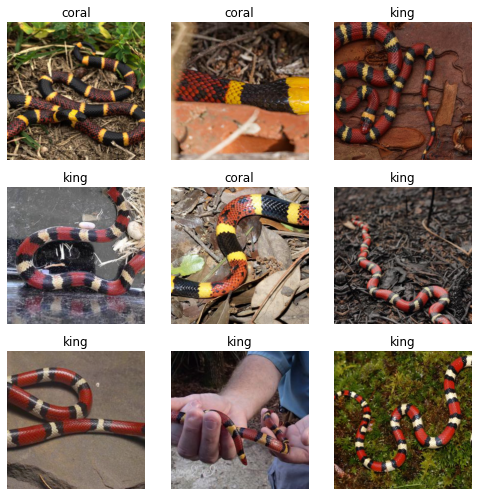

In [11]:
data.show_batch(rows=3, figsize=(7, 7))



In [ ]:
# Resnet 34
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

# OR Resnet 50. Model more memory so probably need to reduce the batch size.
# data.batch_size = bs // 2
# learn = cnn_learner(data, models.resnet50, metrics=error_rate)



In [ ]:
learn.fit_one_cycle(4)
learn.save("stage-1")



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9)



In [ ]:
# Probably will want to reload and try several combinations of max_lr range and number of epochs.
# Re-load, learn, train, note the results. Then repeat with a variation.

learn.load("stage-1")



In [ ]:
learn.unfreeze()
learn.lr_find()
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()



In [ ]:
# Rule of thumb is go with 3e-4 for the 2nd number
# Pick the first number one the graph where the line trends down.
# 3e-5 is roughly halfway between 1e-5 and 1e-4 on a log scale graph
learn.fit_one_cycle(4, max_lr=slice(1e-4, 3e-4))
learn.save("stage-2")



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9)



In [ ]:
# Export the trained model to a file.
learn.export(train_path / "trained_model.pkl")

